**Readout Calibration Introduction**

Quantum readout is the process of extracting information from quantum bits (qubits) and converting it into classical bits. In most quantum algorithms, outputs are probability distributions of bit strings, obtained through repeated circuit executions. These bit strings exist in a space represented by $\left \{ 0,1 \right \} ^{N_q}$, where $N_q$ is the number of qubits. The observed probability of a specific bit string reflects its amplitude in the measured quantum superposition state. At a physical level, readout involves probing the qubit system and estimating its quantum state using physical quantities. For instance, in superconducting transmon qubits, readout is achieved by coupling the qubit's frequency $\omega_q$ with the frequency of a readout resonator $\omega_r$. The state of each qubit is classified based on the frequency shift detected in the readout resonator.

$$
\begin{equation*} 
    \begin{aligned}
        \Delta \omega_r = g^2/|\omega_q-\omega_r|
    \end{aligned}
\end{equation*}
$$
where $g$ is a constant coupling strength[<sup>[1]</sup>](#R1). By comparing the drift with a threshold, we can discriminate whether each bit is 0 or 1 in the bit string. 

**Matrix-based Calibration**

Mathematically, readout error perturbs the probability distribution, expressed as a linear transformation from the ideal distribution $P_{\text{ideal}}$ to the measured distribution $P_{\text{measured}}$:

$$
\begin{equation*} 
\small
P_{measured} = M P_{ideal},
\end{equation*}
$$
where $M$ is defined as the noise matrix with the size of $2^{N_q} \times 2^{N_q}$. Theoretically, the noise matrix can be characterized by running benchmarking circuits with every basis state as input.

<div style="text-align:center;">
    <img src="background.jpg"  width="50%" height="50%">
</div>


In step 1 of Figure , $2^{N_q}$ benchmarking circuits are executed, preparing all possible basis states (no superposition). We assume the initial state to be ideal, prepared by high-fidelity single-qubit gates, similar to prior works[<sup>[2]</sup>](#R2)[<sup>[3]</sup>](#R3). The noise matrix is then filled based on the output probability distribution after execution:

$$
\begin{equation*} 
\begin{aligned}
& M[x][y]=P(measure=x ~~|~~ prepare=y).
\end{aligned}
\end{equation*}
$$

After getting the noise matrix $M$, we can calibrate any measured probability distribution from this quantum device using its inverse $M^{-1}$, namely calibration matrix. The calibration is conducted via an MVM operator between the measured distribution and the calibration matrix:
$$
\begin{equation*} 
\small
P_{calibrated} = M^{-1} P_{measured}.
\end{equation*}
$$
The step 2 in Figure is an example of a 2-qubit calibration. 

The existing methodologies[<sup>[4]</sup>](#R4)[<sup>[5]</sup>](#R5)[<sup>[6]</sup>](#R6) are fundamentally limited in either scalability or accuracy. Inspired by the classical finite element method (FEM), a formal method to model the complex interaction between elements, we present our calibration framework named QuFEM.

In [1]:
import os
os.chdir('..')

from simulator.noisy_simulator import NoisySimulator
from data_objects.backend import LinearBackend
from simulator.readout_error_model import ReadoutErrorModel
from optimizations.readout_mitigation.fem import Mitigator
from optimizations.readout_mitigation.fem import IterativeSamplingProtocol, EnumeratedProtocol
from data_objects.algorithms import get_algs, ibu_response_matrix
from qiskit.quantum_info.analysis import hellinger_fidelity
from optimizations.readout_mitigation.fem.tools import npformat_to_statuscnt,statuscnt_to_npformat
from time import time
import pickle
import matplotlib.pyplot as plt
import logging
logging.getLogger('qiskit').setLevel(logging.ERROR)

/home/zhanghanyu/anaconda3/envs/read_sp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-02 08:17:48,891	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


**Run a 5-qubit GHZ Circuit on the Simulator**

+ n_qubits: The number of qubits

+ samples: Circuit sampling frequency

+ output_noise: The noisy output

+ output_ideal: The ideal result

**Linear Backend Simulator**

+ topology: Each qubit is connected to its two adjacent qubits

+ adjlist: Describes the distance relationship between qubits

In [2]:
n_qubits = 5
samples = 10000
backend = LinearBackend(n_qubits, 1)
simulator = NoisySimulator(
    backend, readout_error_model = ReadoutErrorModel.random_model(backend))

circuit = get_algs(n_qubits, backend, algs = ['ghz'])[0]
output_noise = simulator.execute(circuit,samples)

outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}
print("Uncalibrated Algorithm Fidelity : ",hellinger_fidelity(outout_ideal,output_noise))

Uncalibrated Algorithm Fidelity :  0.7510968013443864


**Baseline: Iterative Bayesian Unfolding**

The Google Quantum Team introduces the Iterative Bayesian Updates (IBU)[<sup>[4]</sup>](#R4) method, which iteratively utilizes new measurement data. This approach combines prior information with fresh data using Bayesian inference to derive the posterior distribution of the system's state. Through successive iterations, this posterior distribution gradually refines, thereby improving the precision of quantum system calibration. Let $\vec{p}$ be the noisy distribution, $\vec{\theta } ^{k}$ be the kth iteration guess of the error-mitigated distribution and $R$ be the noise matrix. Then, the IBU update rule is:
$$
    \begin{aligned}\vec{\theta } ^{k+1} &=\sum_{i=1}^{2^{n} } p_{i} \cdot \frac{R_{i}\odot \vec{\theta } ^{k} }{R_{i}\vec{\theta } ^{k} }\\&= \vec{\theta } ^{k}\odot \left ( R^{T} \left ( \vec{p}\oslash R \vec{\theta } ^{k} \right )  \right ) \end{aligned}
$$
Here, $\odot$ is element-wise multiplication, and $\oslash$ is elementwise division.

**IBU Parameterss**

+ matrices: a list of 2x2 conditional probability tables representing error probabilities for each qubit

+ method: "reduced" or "full"

+ max_iters: Maximum number of iterations

+ tol: Convergence value

+ ham_dist: Hamming distance

In [3]:
from baselines.readout_calibration.IBU.src.IBU import IBU
from baselines.readout_calibration.IBU.utils.qc_utils import *
from baselines.readout_calibration.IBU.utils.data_utils import *

matrices = []
for i in range(n_qubits):
    qc_t_0 = ibu_response_matrix(n_qubits, backend,i,0)[0]
    qc_t_1 = ibu_response_matrix(n_qubits, backend,i,1)[0]
    output_0 = simulator.execute(qc_t_0,1000)
    output_1 = simulator.execute(qc_t_1,1000)
    p_0_0 = output_0['0']/1000
    p_1_1 = output_1['1']/1000
    mat = np.array([[p_0_0, 1-p_0_0], [1-p_1_1, p_1_1]])
    matrices.append(mat)


params = {
    "exp_name": "ghz",
    "method": "reduced",  
    "library": "jax",  
    "num_qubits": n_qubits,
    "max_iters": 1000,
    "tol": 1e-5,
    "use_log": False,  
    "verbose": True,
    "init": "unif",  
    "smoothing": 1e-8,
    "ham_dist": 3
}

2024-04-02 08:18:00.296210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
ibu = IBU(matrices, params)
ibu.set_obs(dict(output_noise))
ibu.initialize_guess()
t_ibu_1 = time()
t_sol, max_iters, tracker = ibu.train(params["max_iters"], tol=params["tol"], soln=outout_ideal)
t_ibu_2 = time()
outout_ibu = ibu.guess_as_dict()
t_ibu = t_ibu_2 - t_ibu_1

print("Algorithm Fidelity with IBU : ",hellinger_fidelity(outout_ideal,outout_ibu).item())
print("IBU time: ",t_ibu)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 32/32 [00:00<00:00, 357913.94it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:   6%|▌         | 56/1000 [00:00<00:14, 63.89it/s]


Waiting for JAX to return control flow...
Algorithm Fidelity with IBU :  0.9513115286827087
IBU time:  0.9220092296600342


**QuFEM: Fast and Accurate Quantum Readout Calibration Using the Finite Element Method**

QuFEM is a framework for calibrating the measurement error using finite element method. It reduces the time complexity of benchmarking circuits for noise matrix characterization from exponential $\mathscr{O}(2^n)$ to polynomial $\mathscr{O}(n^2)$ and accelerates the end-to-end calibration.

<div style="text-align:center;">
    <img src="FEM.jpg"  width="40%" height="40%">
</div>

QuFEM divides the qubits involved in the measured circuit output into multiple groups. It defines the circuit output $P_{measured}$ as $P_{1}$, and the calibration output $P_{calibrated}$ as $P_{L+1}$. QuFEM reformulates the calibration as an iterative process with a series of sub-noise matrices.
$$
\begin{aligned} 
    \text{Iter. 1:~~~} & P_{2} = (M_{1,1} \otimes M_{1,2} \otimes \cdots M_{1,K})^{-1} P_{1}, \\
    \text{Iter. 2:~~~} & P_{3} = (M_{2,1} \otimes M_{2,2} \otimes \cdots M_{2,K})^{-1} P_{2}, \\
    &  \cdots, \\
    \text{Iter. $L$:~~~} & P_{L+1} = (M_{L,1} \otimes M_{L,2} \otimes \cdots M_{L,K})^{-1} P_{L}, \\
\end{aligned}
$$
where $M_{i,j}$ is the sub-noise matrix of the $j^{{\th}}$ qubit group in the $i^{{\th}}$ iteration. $\otimes$ is the tensor-product to composite these sub-noise matrices. $P_2$ to $P_L$ serve as the intermediate probability distributions that iteratively approximate the ideal probability distribution.

**Benchmarking Circuit Generation**

To reduce the number of benchmarking circuits and maintain high accuracy, we identify the circuits that enable the high qubit interactions and profile their execution results, while the circuits with low interactions mainly involve qubit-independent errors so that their outputs can be easily modeled without program executions. We define a metric $\theta$ to distinguish the critical interaction.
$$
    \begin{aligned}
        \theta = \frac{interact(q_i.ideal=x \rightarrow q_j.ideal=y)}{num(q_i.ideal=x \rightarrow q_j.ideal=y)}  \\
    \end{aligned}
$$
 $\theta$ naturally decreases with the number of benchmarking circuits. We set a threshold $\alpha$ to specify the desired accuracy and reduce the number of benchmarking circuits.


In [5]:
protocol = EnumeratedProtocol(n_qubits)
real_bstrs, circuits_protocol = protocol.gen_circuits()

all_statuscnts = [
    simulator.execute(cir_protocol, samples)
    for cir_protocol in circuits_protocol
]

protocol_dataset = [statuscnt_to_npformat(p) for p in all_statuscnts]
protocol_dataset_all =  [[x, y] for x, y in zip(real_bstrs, protocol_dataset)]
protocol_iterative = IterativeSamplingProtocol(backend, hyper = 1, n_samples_iter = 5, threshold = 1e-4)
statuscnts = protocol_iterative.get_data(protocol_dataset_all)

protocol_statuscnts = [npformat_to_statuscnt(statuscnts[i][1]) for i in range(len(statuscnts))]
bstrs = [statuscnts[i][0] for i in range(len(statuscnts))]

print("The originally required number of circuits : ",len(all_statuscnts))
print("The number of circuits required by QUFEM : ",len(statuscnts))

new filter:  (1, 3, 1, 2)
new filter:  (3, 4, 0, 0)
new filter:  (4, 0, 1, 0)
new filter:  (4, 0, 1, 0)
new filter:  (2, 1, 0, 0)
new filter:  (2, 1, 0, 0)
new filter:  (3, 1, 0, 2)
new filter:  (4, 1, 1, 0)
new filter:  (1, 4, 1, 0)
new filter:  (3, 4, 0, 0)
new filter:  (2, 3, 0, 2)
new filter:  (3, 1, 1, 0)
new filter:  (4, 0, 0, 0)
new filter:  (3, 1, 0, 1)
new filter:  (3, 1, 0, 0)
new filter:  (2, 3, 0, 0)
new filter:  (1, 4, 1, 1)
new filter:  (1, 2, 1, 2)
new filter:  (1, 2, 1, 0)
new filter:  (2, 3, 0, 1)
new filter:  (4, 1, 1, 1)
new filter:  (1, 2, 1, 2)
new filter:  (1, 4, 1, 2)
new filter:  (3, 2, 0, 0)
new filter:  (2, 4, 0, 1)
new filter:  (2, 3, 0, 1)
new filter:  (3, 2, 0, 1)
new filter:  (4, 3, 1, 0)
new filter:  (2, 4, 0, 2)
new filter:  (2, 0, 0, 1)
new filter:  (3, 2, 0, 2)
new filter:  (3, 4, 0, 1)
new filter:  (1, 3, 1, 2)
new filter:  (4, 2, 1, 0)
new filter:  (4, 3, 1, 2)
new filter:  (2, 1, 0, 2)
new filter:  (3, 2, 0, 2)
new filter:  (3, 1, 1, 1)
new filter: 

/home/zhanghanyu/JanusQ/optimizations/readout_mitigation/fem/benchmarking.py:289: RuntimeWarning: invalid value encountered in divide
  iter_states_error = states_error / states_count


**Weighted Graph Construction and Qubit Partition**

We use various grouping schemes in calibration to address local qubit interactions, aiming to maximize locality within groups. To achieve this, qubit interactions are quantified using a weighted graph.
For each shot of the circuit execution, the operation and the readout output of a qubit are recorded as a triple:
- *ideal* $\in \{0, 1, \varnothing\}$: This value records the ideal~(initial) basis state that the qubit is prepared in the circuit.
- *measured* $\in \{0, 1, \varnothing\}$: This value records the measured output of the qubit in this shot.
- *ef* $\in \{0, 1\}$: This is the abbreviation of the error flag, where 0 means the measured output matches the ideal result, and 1 means the error occurs.

 An interaction $q_i.ideal=x \rightarrow q_j.ideal=y$ is defined as:
\begin{equation*} 
    \begin{aligned}
        &\text{interact}(q_i.\text{ideal}=x \rightarrow q_j.\text{ideal}=y)= \\
        & ~~~~~~~~~~~\big| p(q_j.\text{ef}=1~|~C1, C2)-p(q_j.\text{ef}=1~|~C2)\big|\\
        & \text{C1: } q_i.\text{ideal}=x,~~~\text{C2: } q_j.\text{ideal}=y
    \end{aligned}
\end{equation*}
where $x \in \{0, 1, \varnothing\}$, $y \in \{0, 1\}$.

The weight between two qubits by collecting all cases of interactions:
\begin{equation*} 
\begin{aligned}
    weight(q_i,q_j) = & \sum_{\mathclap{x\in\{0, 1, \varnothing\}, y\in\{0,1\}}} \text{interact}(q_i.\text{ideal}=x \rightarrow q_j.\text{ideal}=y) \\
    + & \sum_{\mathclap{x\in\{0, 1, \varnothing\}, y\in\{0,1\}}} \text{interact}(q_j.\text{ideal}=x \rightarrow q_i.\text{ideal}=y) 
\end{aligned} 
\end{equation*}
We then construct a qubit graph. The edge of the graph is labeled by the weight. We leverage the MAX-CUT solver to partition qubits in the graph into groups.


**QuFEM Parameterss**

+ n_iters: Iteration count

+ roup_size: Group size

+ partation_methods: "random" or "max-cut"

In [7]:
mitigator = Mitigator(n_qubits, n_iters = 2)
scores = mitigator.init((bstrs, protocol_statuscnts), group_size=2, partation_methods=[
                         'max-cut'],multi_process=False)

t_qufem_1 = time()
output_fem = npformat_to_statuscnt(mitigator.mitigate(output_noise))
t_qufem_2 = time()
t_qufem = t_qufem_2-t_qufem_1
print("Algorithm Fidelity with QuFEM using max-cut method: ",hellinger_fidelity(outout_ideal,output_fem))
print("QuFEM time: ",t_qufem)

scores_random = mitigator.init((bstrs, protocol_statuscnts), group_size=2, partation_methods=[
                         'random'],multi_process=False)
output_fem_rd = npformat_to_statuscnt(mitigator.mitigate(output_noise))
print("Algorithm Fidelity with QuFEM using random method': ",hellinger_fidelity(outout_ideal,output_fem_rd))

0it [00:00, ?it/s]

242it [00:00, 492.68it/s]
242it [00:00, 1758.87it/s]


Algorithm Fidelity with QuFEM using max-cut method:  0.9955995113508916
QuFEM time:  0.004447460174560547
Algorithm Fidelity with QuFEM using random method':  0.9955585389073167


**Random or Max-cut**

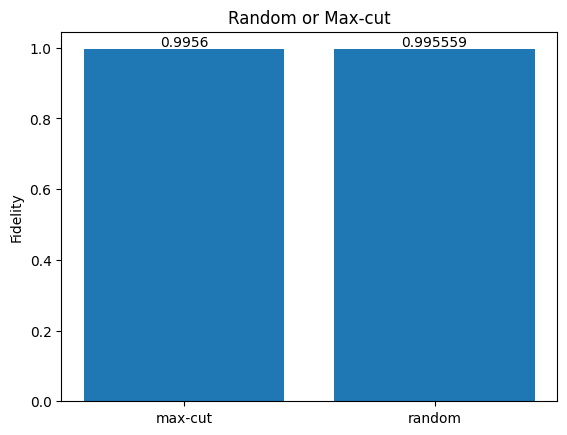

In [17]:
values = [hellinger_fidelity(outout_ideal,output_fem), hellinger_fidelity(outout_ideal,output_fem_rd)]
labels = ['max-cut', 'random']


plt.bar(labels, values)
for i in range(len(labels)):
    plt.text(i, values[i], round(values[i], 6), ha='center', va='bottom')

plt.title('Random or Max-cut')
plt.ylabel('Fidelity')
plt.show()

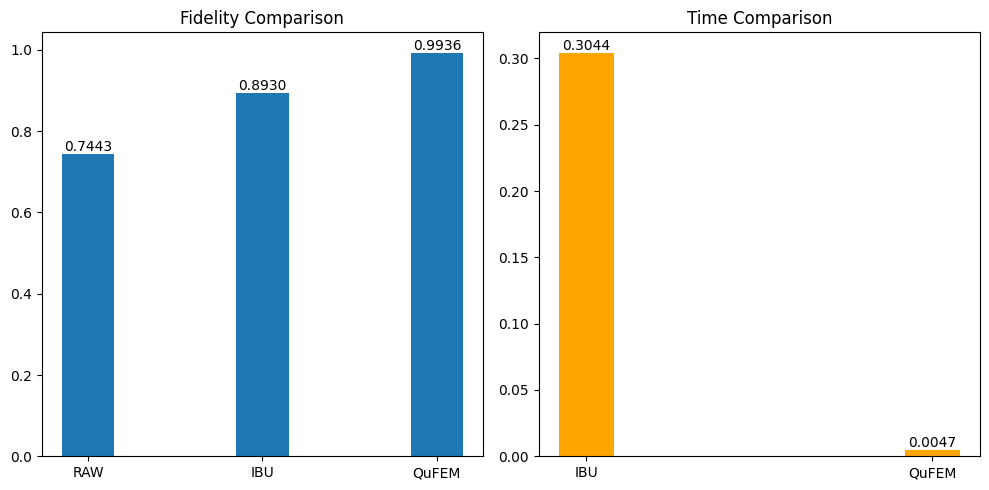

In [14]:
values_fid = [hellinger_fidelity(outout_ideal,output_noise), hellinger_fidelity(outout_ideal,outout_ibu).item(), hellinger_fidelity(outout_ideal,output_fem)]
labels_fid = ['RAW', 'IBU', 'QuFEM']

bar_width = 0.3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(labels_fid, values_fid, width=bar_width)
axs[0].set_title('Fidelity Comparison')
for i, value in enumerate(values_fid):
    axs[0].text(i, value, '{:.4f}'.format(value), ha='center', va='bottom')


values_t = [t_ibu, t_qufem]
labels_t = [ 'IBU', 'QuFEM']

axs[1].bar(labels_t, values_t, width=0.16, color='orange')
axs[1].set_title('Time Comparison')

for i, value in enumerate(values_t):
    axs[1].text(i, value, '{:.4f}'.format(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Results**

We propose QuFEM to calibrate the measurement error. First, we formulate the calibration as a series of tensor-product operations involving sub-noise matrices, where the matrix is iteratively updated with the probability distribution. Then, we introduce how to generate the benchmarking circuits with low time complexity for characterization. Experiments demonstrate that Qufem has higher fidelity and faster calibration speed compared to IBU (reduced = 3).

**References**



<div><a name="R1"></a>
[1] Philip Krantz, Morten Kjaergaard, et al. A quantum engineer’s guide to
superconducting qubits[J]. Applied Physics Reviews, 2019.
</div>


<div><a name="R2"></a>
[2] Sergey Bravyi, Sarah Sheldon, et al. Mitigating measurement errors in multiqubit experi-
ments[J]. Physical Review A, 2021.
</div>

<div><a name="R3"></a>
[2] P. Rebentrost, M. Mohseni, et al. Quantum support vector
machine for big feature and big data classification[J]. Physical Review
Letters, 2013.
</div>


<div><a name="R4"></a>
[4] Satzinger K J, Liu Y J, Smith A, et al. Realizing topologically ordered states on a quantum processor[J]. Science, 2021.
</div>

<div><a name="R5"></a>
[5] Nation P D, Kang H, Sundaresan N, et al. Scalable mitigation of measurement errors on quantum computers[J]. PRX Quantum, 2021.
</div>

<div><a name="R6"></a>
[6] Bravyi S, Sheldon S, Kandala A, et al. Mitigating measurement errors in multiqubit experiments[J]. Physical Review A, 2021.
</div>

<div><a name="R7"></a>
[7]  Beijing Academy of Quantum Information Sciences. Quafu quantum cloud computing platform. https://quafu.baqis.ac.cn/
</div>



